In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pylab as pl

from sklearn.cross_validation import cross_val_score 
from sklearn.cross_validation import KFold
import sklearn.preprocessing as pp
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso
from sklearn.decomposition import RandomizedPCA
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn import cross_validation
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve
import sklearn.decomposition
import sklearn.ensemble as sk
from sklearn import linear_model
from sklearn.svm import LinearSVR
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_predict

import random
import sys
from scipy import stats
% matplotlib inline
%load_ext autoreload
%autoreload 2
from regression_functions import *
from reg_plots import *


## Import POD Data

In [2]:
pod_number = 'cham_4'

In [3]:
df_pod = pd.io.parsers.read_csv(filepath_or_buffer = 'data/cham_4_closed_only.csv', parse_dates = [0], index_col = 0)
# df_pod = df_pod.rename(columns={'o3_ppb': 'O3_ppb'})

## Import reference data

In [4]:
df_ref = pd.DataFrame.from_csv('data/coll_2b.csv', index_col=0, parse_dates=True)
df_ref = df_ref.rename(columns={'c_close': 'O3_ppb'})
df_ref = df_ref.drop('c_open', axis=1)

In [5]:
df_ref.head()

,O3_ppb
date,
2014-07-18 16:39:00,42.369
2014-07-18 17:42:00,37.207
2014-07-18 18:46:00,46.415
2014-07-18 19:49:00,18.391
2014-07-18 20:53:00,30.103


In [6]:
resamp_time = '1H'
df_all = pd.concat([df_pod.resample(resamp_time), df_ref.resample(resamp_time)], axis=1).dropna()

In [7]:
df_all.tail()

,e2v03,no2,Temp,Rh,ln_O3,ln_temp,ln_rh,e2v03_int_lag_1,e2v03_int_lag_3,e2v03_int_lag_5,...,Temp_interact_ln_temp,Temp_interact_Rh,Temp_interact_ln_rh,ln_temp_sq,ln_temp_interact_Rh,ln_temp_interact_ln_rh,Rh_sq,Rh_interact_ln_rh,ln_rh_sq,O3_ppb
date,,,,,,,,,,,,,,,,,,,,,
2014-07-25 05:00:00,452.567568,652.864865,26.845946,29.859459,6.114935,3.290077,3.396451,0,905.351351,1810.918919,...,88.327258,801.542703,91.178844,10.824683,98.237582,11.174507,891.678378,101.419225,11.535980,13.2460
2014-07-25 06:00:00,464.405405,621.297297,26.759459,31.951351,6.140757,3.286831,3.464100,0,928.702703,1857.297297,...,87.956877,854.871622,92.693414,10.803371,105.013847,11.385760,1021.123784,110.690000,12.000217,9.3257
2014-07-25 07:00:00,530.540541,701.297297,31.500000,28.421622,6.273886,3.449909,3.347052,0,1060.121622,2119.351351,...,108.677079,895.144324,105.427324,11.902030,98.047676,11.546873,807.945946,95.134210,11.202956,27.5340
2014-07-25 08:00:00,599.513514,777.972973,40.416216,22.043243,6.396118,3.699204,3.092806,0,1198.810811,2397.405405,...,149.510038,890.782162,124.993946,13.684162,81.539418,11.440781,486.097297,68.184277,9.565851,16.5730
2014-07-25 09:00:00,653.710526,804.947368,44.223684,19.194737,6.482663,3.789217,2.954620,0,1307.105263,2613.842105,...,167.576972,848.867105,130.664441,14.358254,72.733145,11.195702,368.450000,56.713777,8.729811,25.4530


#### Declare whether to process raw or filtered data.

In [8]:
which_data = 0    #1 = filtered, 0 = raw
ref_column, leave_out_pod, pod_ozone = declare_filt_or_raw_dataset(which_data)

#### Call the scaling function and create a dataframe with scaled data.

In [9]:
df_scaled, features, minmax_scale_fit, standard_scale_fit = scale_features_and_create_day_column(df_all, ref_column)
len(df_scaled)

78

#### Declare whether you'd like to use holdout dates from a previous run.

In [10]:
prev_holdout = "true"
chunks = ['7-24 PM']

#### Add a 'day' column to the dataframe, and separate the data into training and holdout.

In [11]:
if prev_holdout == "true":
    df_tr, df_hold, chunks_tr, days_tr = sep_tr_and_holdout_pre_defined(df_scaled, ref_column, chunks)
else:
    df_tr, df_hold, chunks_tr, days_tr = sep_tr_and_holdout(df_scaled, ref_column)

df_hold ['7-24 PM']


In [12]:
chunks_tr

['7-21 PM', '7-22 AM', '7-22 PM', '7-23 AM', '7-23 PM', '7-24 AM', '7-25 AM']

In [13]:
df_hold['chunk'].unique()

array(['7-24 PM'], dtype=object)

#### Declare a cutoff value for 'high' ozone.

In [14]:
cutoff_value = 40

#### Plot the pod ozone, ref ozone, temp and RH.

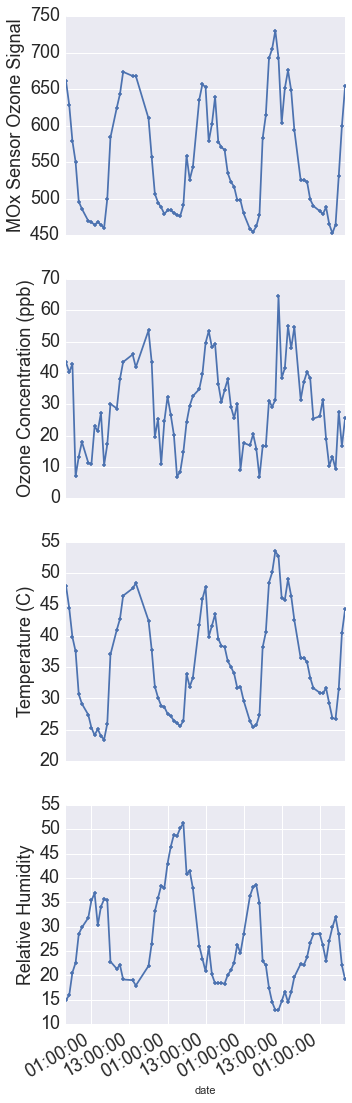

In [15]:
plot_03_temp_rh_no_scale(df_all, None, pod_number, ref_column, 'Training Data', cutoff_value, 5)

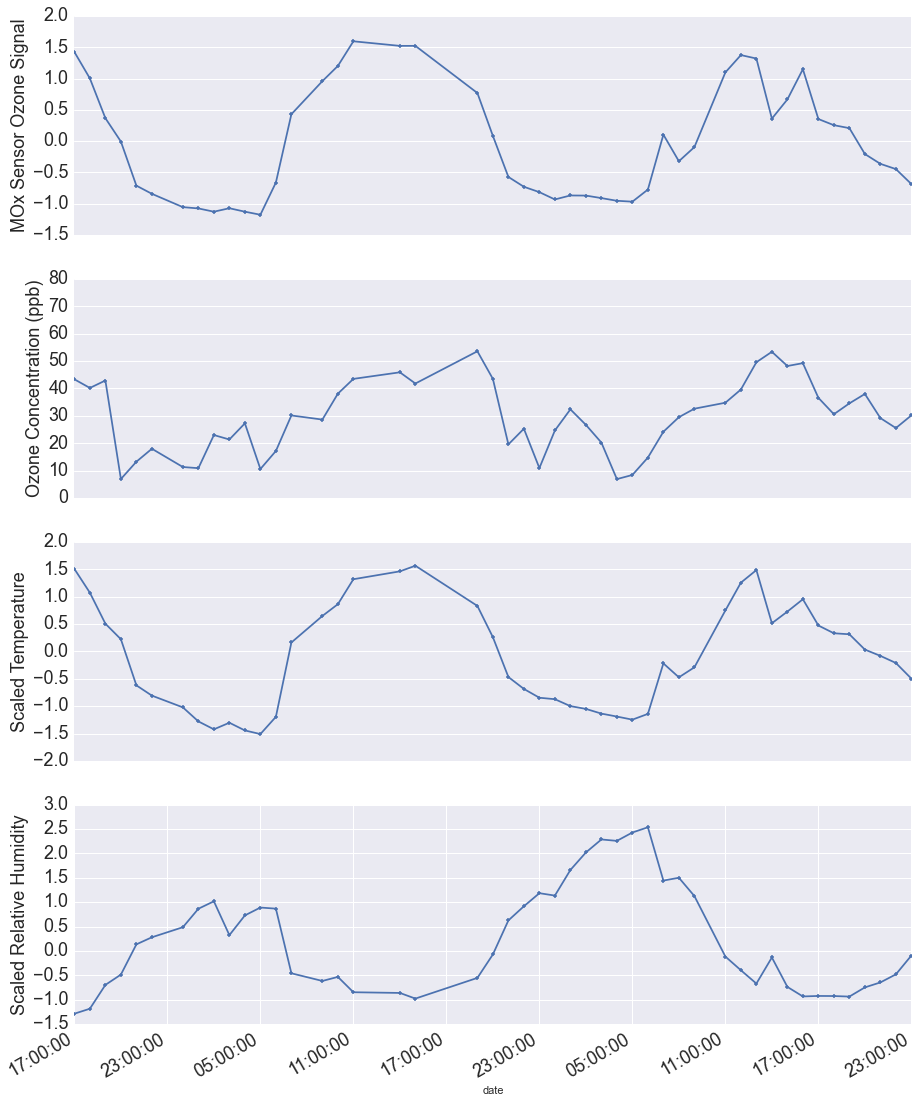

In [16]:
plot_03_temp_rh(df_tr, None, pod_number, ref_column, 'Training Data', cutoff_value, 4)

#### Plot the training ozone

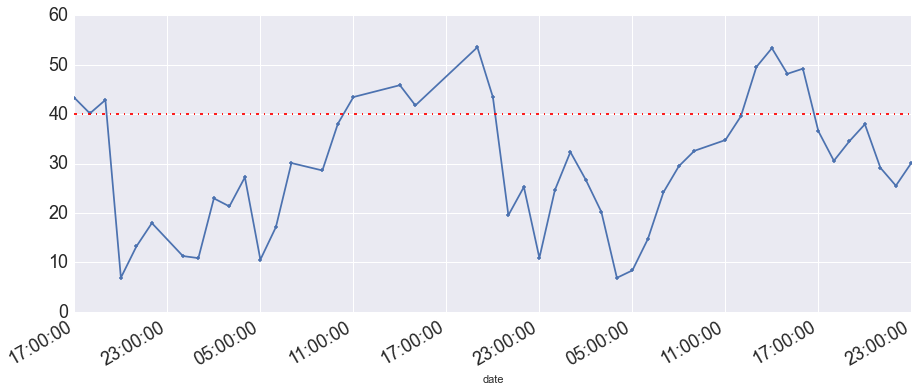

In [17]:
plot_tr_and_holdout(df_tr, None, pod_number, ref_column, 'Training Data', cutoff_value)

#### Plot holdout ozone to make sure that the holdout set has some high-value ozone measurements.

AttributeError: 'FigureCanvasAgg' object has no attribute 'invalidate'

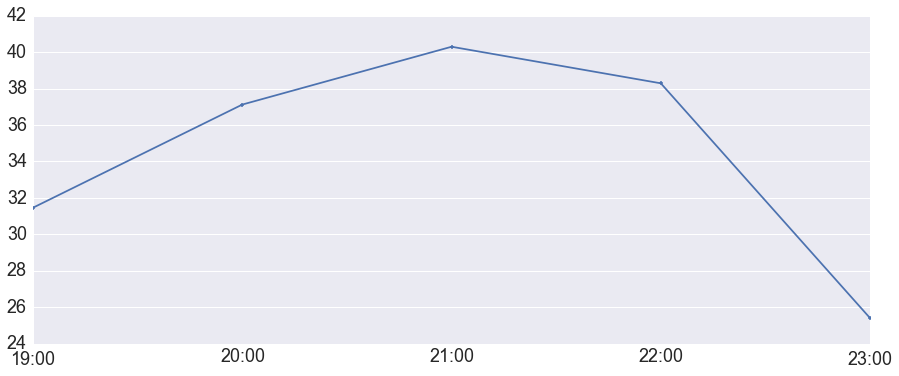

In [197]:
plot_tr_and_holdout(df_hold, None, pod_number, ref_column, 'Holdout Data', cutoff_value)

#### Declare a multiplication factor for the MSE part of the custom score function.

In [18]:
cust_mse_fact = 1

#### Linear Regression with Base Features

In [19]:
base_features = [pod_ozone,'Temp','Rh', 'no2']

/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/seaborn/linearmodels.py:1283: UserWarning: The `corrplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `corrplot` function has been deprecated in favor "
/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/seaborn/linearmodels.py:1349: UserWarning: The `symmatplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `symmatplot` function has been deprecated in favor "


/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


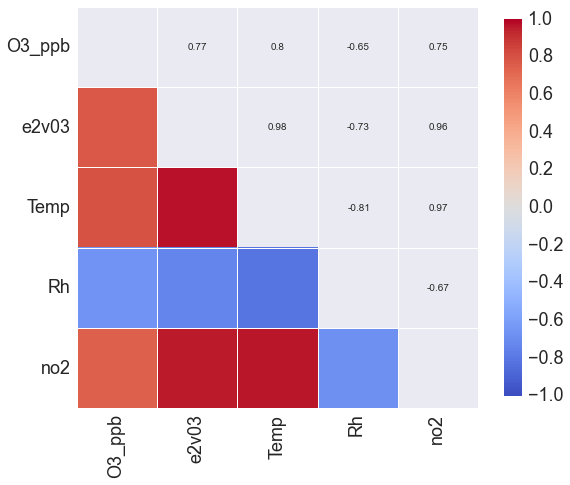

In [20]:
f, ax = plt.subplots(figsize=(9, 9))
sns.corrplot(df_tr[[ref_column] + base_features], annot=True, sig_stars=False,
             diag_names=False, ax=ax)

In [21]:
#Define the model.
lin_regr = linear_model.LinearRegression()
#find the MSE
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_base, y_cv, df_cv_lin_base, df_H_lin_base = cross_validation_by_day(lin_regr, base_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 7.6
Cross-Validation RMSE: 10.0 , High-Value CV RMSE: 9.0 , CV High Diff. in Mean (>40): -16.4
Holdout RMSE: 5.0 , High-Value Holdout RMSE: nan , Holdout High Diff. in Mean.: nan


/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


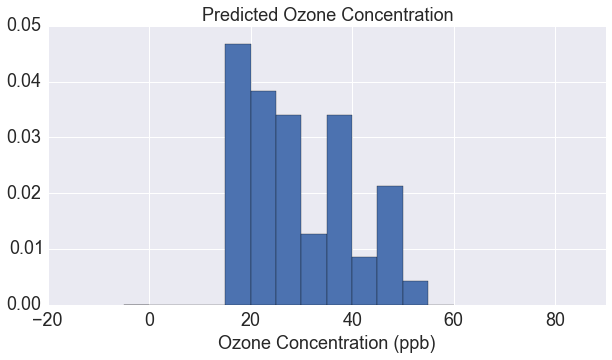

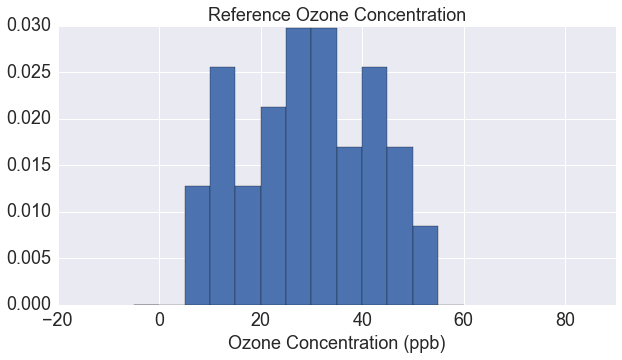

In [22]:
plot_hist(X_pred_cv_base, y_cv, 'Predicted Ozone Concentration')
plot_hist(y_cv, X_pred_cv_base, 'Reference Ozone Concentration')

#### Plot the learning curve for a linear regression with the base features.

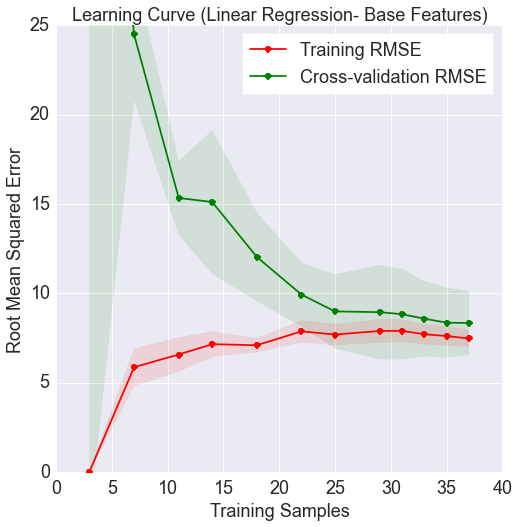

In [23]:
plt = plot_learning_curve(lin_regr, "Learning Curve (Linear Regression- Base Features)", df_tr[base_features].values, df_tr[ref_column].values, (0,25), days_tr, np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1.0]))

The MSE is high for the cross-validation set in this plot, and the training and cross-validation scores come together in this plot tells us that we have resonably high bias. Create more features and add polynomial effects to reduce bias. 

#### Plot the residuals and comparison curves.

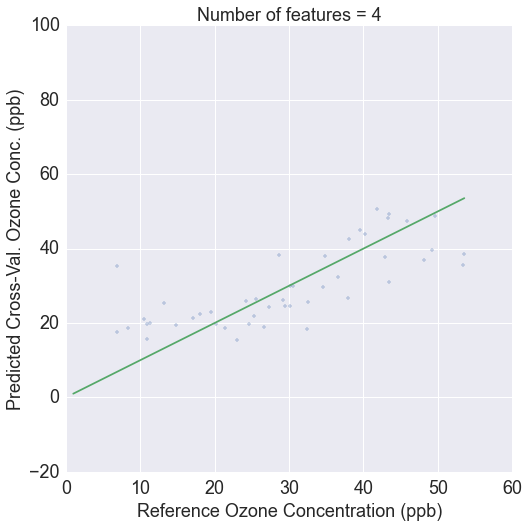

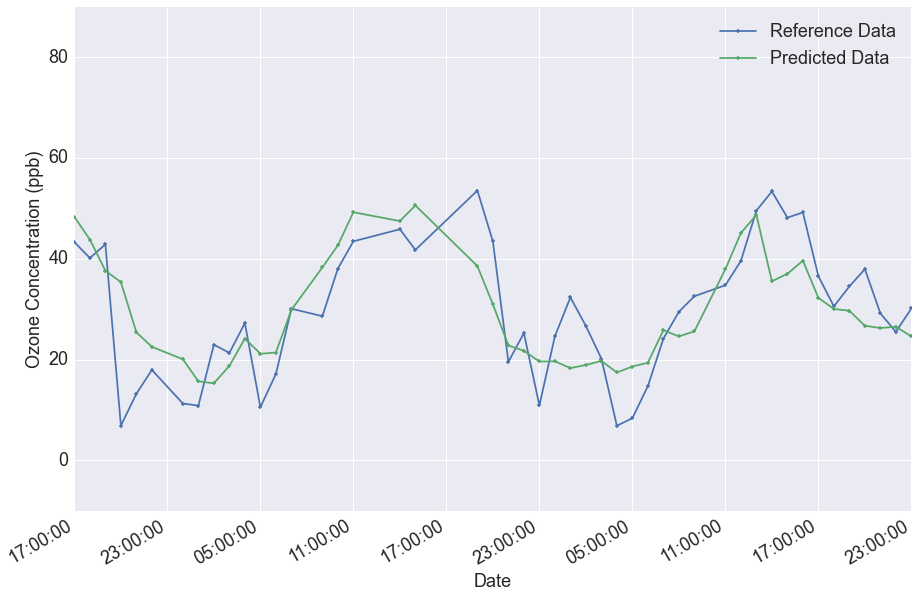

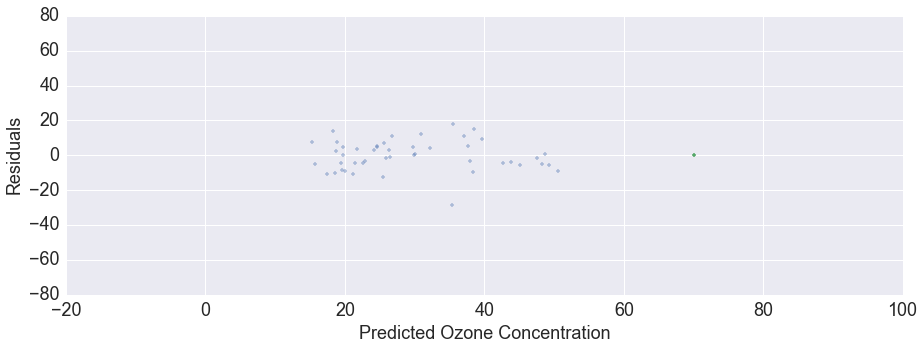

In [24]:
num_good_feat = len(base_features)
fitted_vs_ref_plot(df_cv_lin_base, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 0, ref_column)
resid = plot_resid_vs_conc(df_cv_lin_base, ref_column)

#### Linear Regression with All Features.

In [25]:
every_feature = list(df_tr.ix[:,0:len(df_scaled.columns)])
leave_out = ['ref_o3_smooth', 'chunk', 'day', 'O3_ppb', 'UnixTime']
all_features = [f for f in every_feature if f not in leave_out]
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_all, y_cv, df_cv_lin_all, df_H_lin_all = cross_validation_by_day(lin_regr, all_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 0.0
Cross-Validation RMSE: 49.0 , High-Value CV RMSE: 65.0 , CV High Diff. in Mean (>40): -19.8
Holdout RMSE: 44.0 , High-Value Holdout RMSE: nan , Holdout High Diff. in Mean.: nan


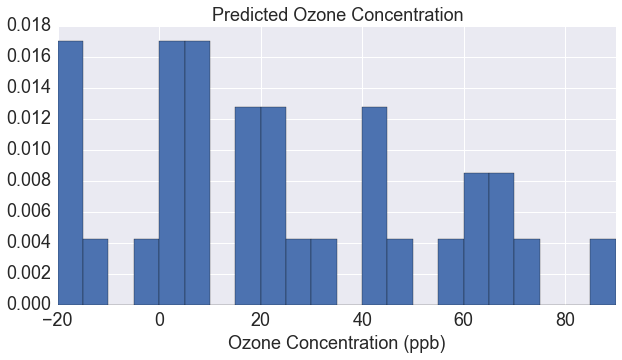

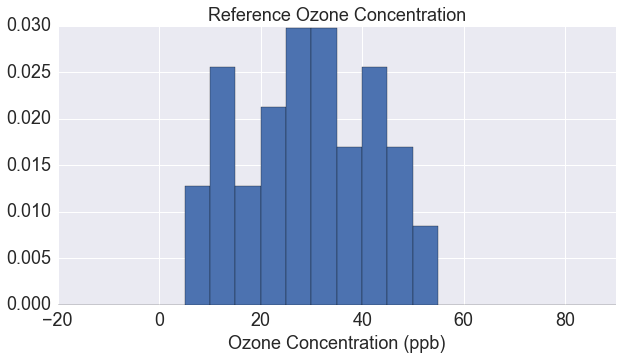

In [26]:
plot_hist(X_pred_cv_all, y_cv, 'Predicted Ozone Concentration')
plot_hist(y_cv, X_pred_cv_all, 'Reference Ozone Concentration')

#### Plot the residuals and comparison curves.

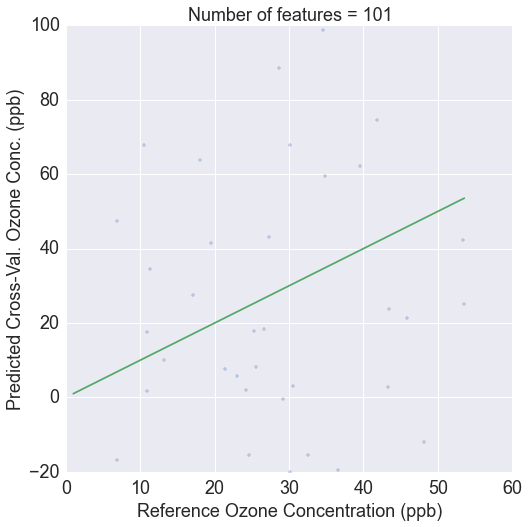

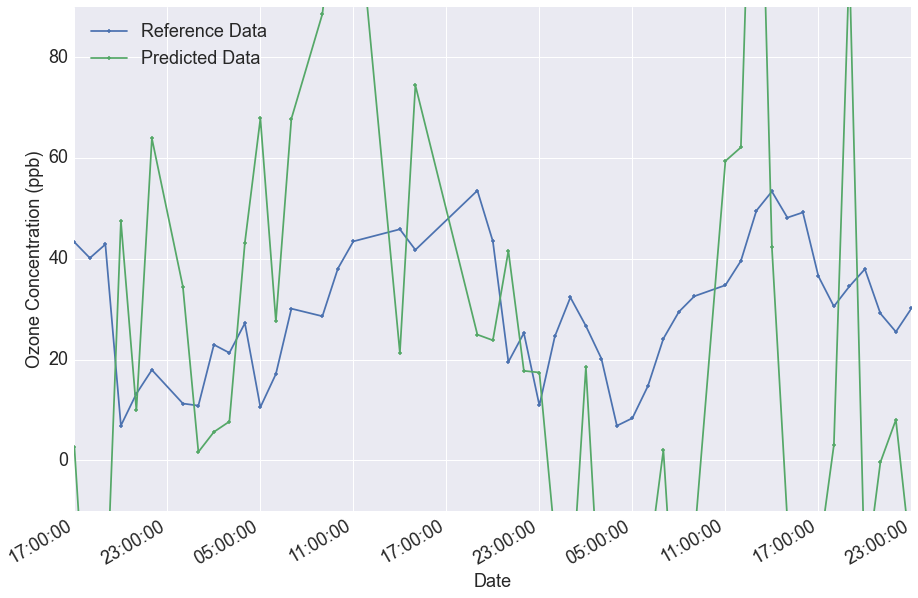

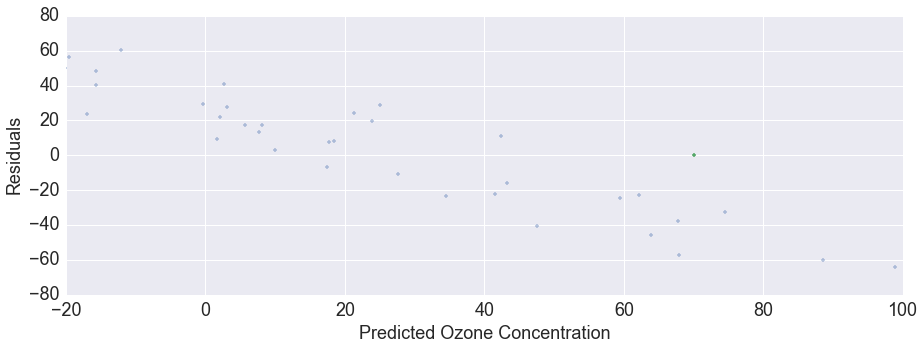

In [27]:
num_good_feat = len(all_features)
fitted_vs_ref_plot(df_cv_lin_all, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 0, ref_column)
resid = plot_resid_vs_conc(df_cv_lin_all, ref_column)

## Forward Selection

#### Declare rather you want to use MSE or a custom error function:

In [28]:
#make a list of features from the column titles in the dataframe
features_all = list(df_tr.columns)
leave_out = ['Zenith Angle [degrees]','UnixTime', 'pod_o3_smooth', 'O3_ppb', 'ref_o3_smooth', ref_column, 'chunk']
features = [f for f in features_all if f not in leave_out]
features_it = [f for f in features if f not in 'day']
fs_features, score, RMSE = forward_selection_lodo(lin_regr, features_it, df_tr[[ref_column] + features].dropna(), 'custom_mse', ref_column, days_tr, 15, cust_mse_fact, cutoff_value)

Next best Feature:  ln_temp , Score:  9.2 RMSE:  5.4 #: 1
Next best Feature:  no2 , Score:  8.7 RMSE:  5.1 #: 2
Next best Feature:  Temp_interact_ln_rh , Score:  8.3 RMSE:  4.2 #: 3
Next best Feature:  Temp_slope_lead_5 , Score:  8.1 RMSE:  3.4 #: 4
Next best Feature:  Temp_slope_lead_1 , Score:  7.7 RMSE:  2.7 #: 5
Next best Feature:  Temp_slope_lag_5 , Score:  7.5 RMSE:  2.5 #: 6
Next best Feature:  ln_temp_int_lead_3 , Score:  7.4 RMSE:  2.7 #: 7
Next best Feature:  ln_temp_slope_lead_1 , Score:  7.2 RMSE:  2.6 #: 8
Next best Feature:  Temp_slope_lag_3 , Score:  7.0 RMSE:  2.4 #: 9
Next best Feature:  e2v03_int_lag_1 , Score:  7.0 RMSE:  2.4 #: 10
Next best Feature:  e2v03_int_lead_1 , Score:  7.0 RMSE:  2.4 #: 11
Next best Feature:  ln_O3_int_lag_1 , Score:  7.0 RMSE:  2.4 #: 12
Next best Feature:  ln_O3_int_lead_1 , Score:  7.0 RMSE:  2.4 #: 13
Next best Feature:  Temp_int_lag_1 , Score:  7.0 RMSE:  2.4 #: 14
Next best Feature:  Temp_int_lead_1 , Score:  7.0 RMSE:  2.4 #: 15
Best 

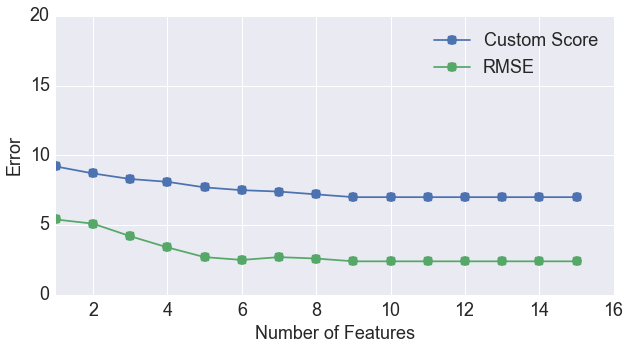

In [29]:
plot_error_vs_features(score, RMSE, [0,20], [1,16])

#### Plot cross-validation fitted data versus reference data, and choose number of features.

/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/sklearn/learning_curve.py:217: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than than the size of 'train_sizes' 9 instead of 10).
  % (train_sizes_abs.shape[0], n_ticks), RuntimeWarning)


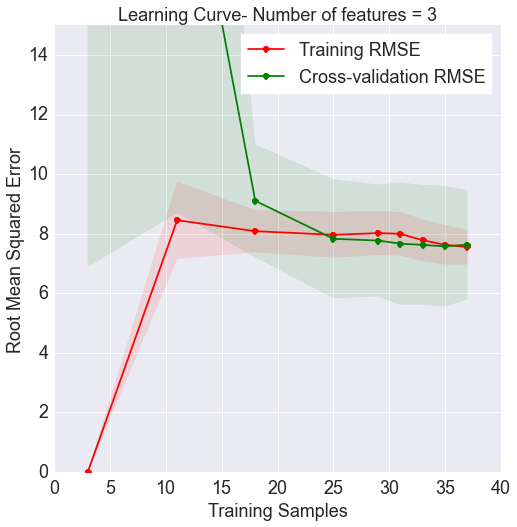

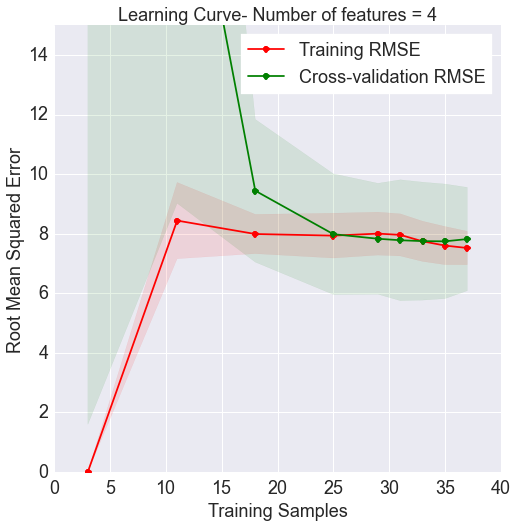

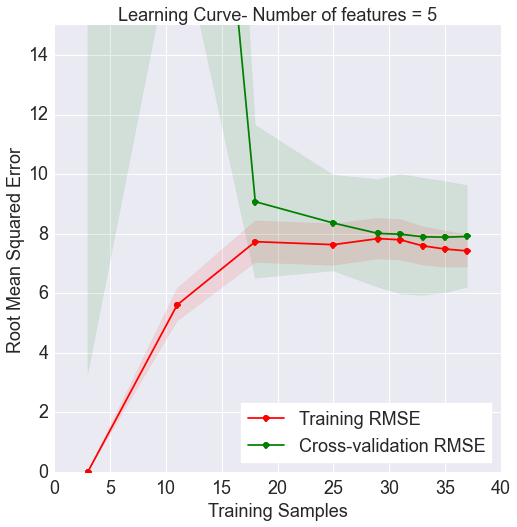

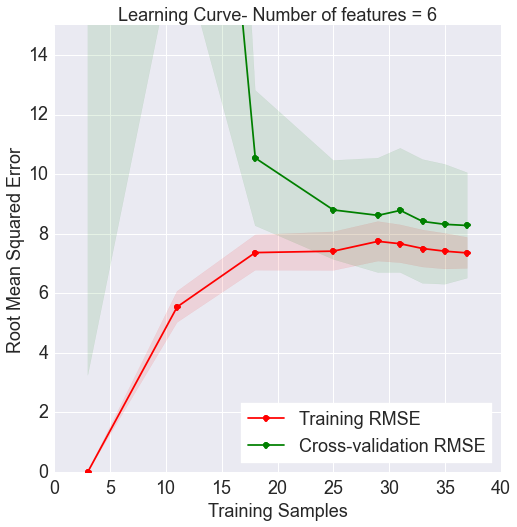

In [30]:
i = 3
while i < 7:
    num_good_feat = i
    #df_cv_1, df_H_1 = find_fitted_cv_values_for_best_features(df_tr, df_hold, fs_features, num_good_feat, linear_model.LinearRegression(), chunks_tr, ref_column)
    #fitted_vs_ref_plot(df_cv_1, i, ref_column) 
    plot_learning_curve(lin_regr, "Learning Curve- Number of features = " + str(i), df_tr[fs_features[:i]].values, df_tr[ref_column].values, (0,15), 5, np.array([0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95,0.97, 1.0]))
    i += 1

#### Enter the chosen number of features, and perform a linear regression.

In [33]:
num_good_feat = 6
best_features = fs_features[:num_good_feat]
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_best, y_cv_best, df_cv_lin_best, df_H_lin_best = cross_validation_by_day(lin_regr, best_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 7.3
Cross-Validation RMSE: 10.0 , High-Value CV RMSE: 6.0 , CV High Diff. in Mean (>40): -13.0
Holdout RMSE: 5.0 , High-Value Holdout RMSE: nan , Holdout High Diff. in Mean.: nan


#### Print Best Features

In [34]:
best_features

['ln_temp',
 'no2',
 'Temp_interact_ln_rh',
 'Temp_slope_lead_5',
 'Temp_slope_lead_1',
 'Temp_slope_lag_5']

In [35]:
X = df_scaled[best_features].values
y = df_scaled[ref_column].values
lin_regr.fit(X, y)
pred = cross_val_predict(lin_regr, X, y)
df_pred = pd.DataFrame({'pred':pred}, index=df_scaled.index)

### Plot the cross-validation data and residuals below.

In [36]:
ref_column

'O3_ppb'

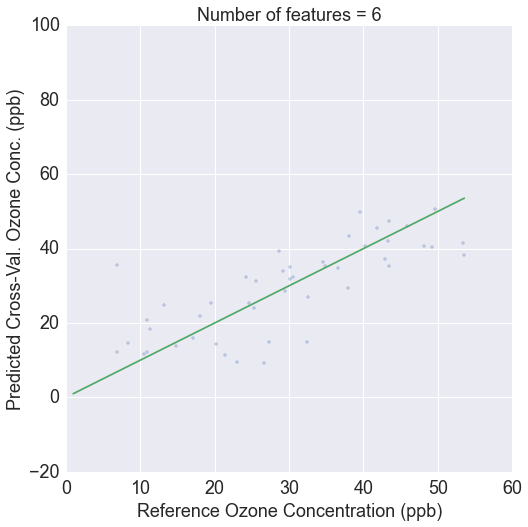

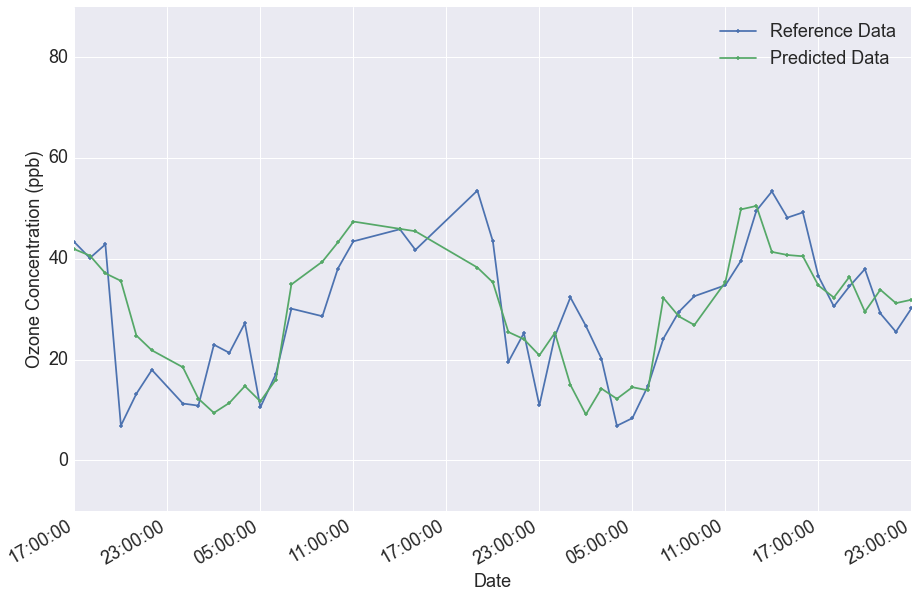

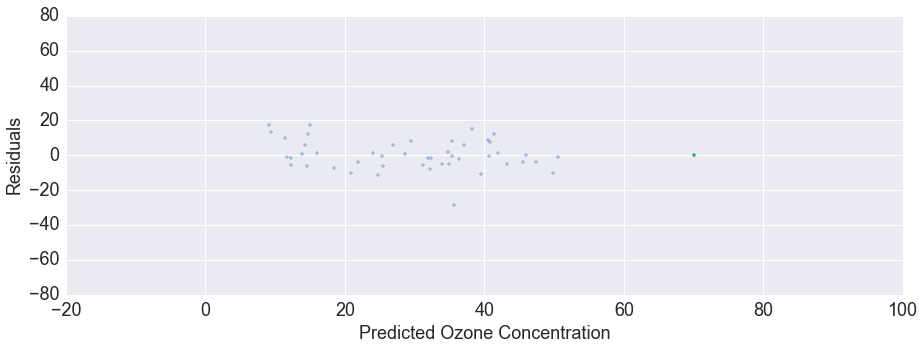

In [37]:
df_lin_regr_best_feat_cv, df_lin_regr_best_feat_H  = find_fitted_cv_values_for_best_features(df_tr, df_hold, fs_features, num_good_feat, linear_model.LinearRegression(), chunks_tr, ref_column)
fitted_vs_ref_plot(df_lin_regr_best_feat_cv, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 0, ref_column)
resid = plot_resid_vs_conc(df_lin_regr_best_feat_cv, ref_column)

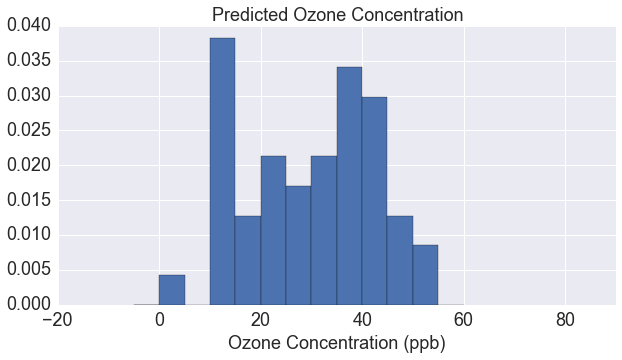

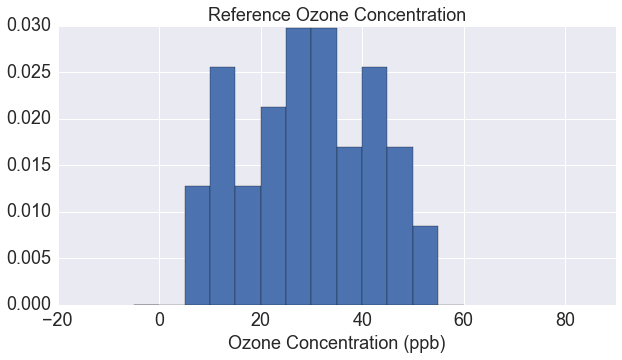

In [38]:
plot_hist(X_pred_cv_best, y_cv_best, 'Predicted Ozone Concentration')
plot_hist(y_cv_best, X_pred_cv_best, 'Reference Ozone Concentration')

## Ridge Regression- All Features

In [39]:
fs_features = all_features
num_good_feat_ridge = len(all_features)

In [40]:
#define the training data
df_fits = df_tr[fs_features[:num_good_feat_ridge] + [ref_column] + ['day']].dropna()
X = df_scaled[fs_features[:num_good_feat_ridge]].values
y = df_scaled[ref_column].values

#### Find the best lambda value using cross-validation

In [245]:
best_lambda_ridge, lambda_ridge, coefs, mean_score_lambda = find_best_lambda(Ridge, fs_features[:num_good_feat_ridge], df_fits, ref_column, 'custom_mse_scoring_function', days_tr, X, y, 0.0000001, 1000000, 3, cust_mse_fact, cutoff_value)

lambda: 1e-07
score: 40.99
lambda: 3e-07
score: 40.98
lambda: 9e-07
score: 40.96
lambda: 2.7e-06
score: 40.92
lambda: 8.1e-06
score: 40.77
lambda: 2.43e-05
score: 40.34
lambda: 7.29e-05
score: 39.16
lambda: 0.0002187
score: 36.38
lambda: 0.0006561
score: 31.74
lambda: 0.0019683
score: 26.56
lambda: 0.0059049
score: 22.37
lambda: 0.0177147
score: 19.21
lambda: 0.0531441
score: 16.5
lambda: 0.1594323
score: 13.55
lambda: 0.4782969
score: 10.27
lambda: 1.4348907
score: 8.58
lambda: 4.3046721
score: 8.92
lambda: 12.9140163
score: 9.5
lambda: 38.7420489
score: 9.9
lambda: 116.2261467
score: 10.33
lambda: 348.6784401
score: 10.99
lambda: 1046.0353203
score: 12.37
lambda: 3138.1059609
score: 14.48
lambda: 9414.3178827
score: 16.16
lambda: 28242.9536481
score: 16.98
lambda: 84728.8609443
score: 17.3
lambda: 254186.582833
score: 17.41
lambda: 762559.748499
score: 17.45
Best Lambda: 1.4348907


#### Plot the values of lambda versus the coefficients and the custom score. 

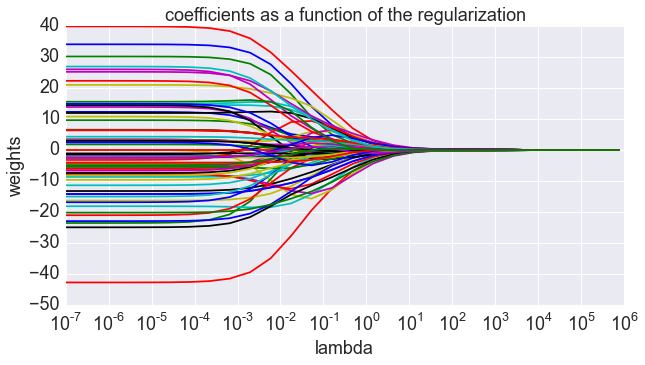

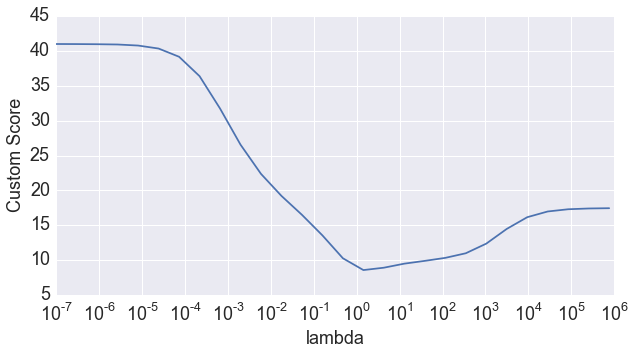

In [246]:
plot_lambda(lambda_ridge, coefs, mean_score_lambda)

#### Use the best lambda value found above to find errors.

In [247]:
MSE_CV_ridge, MSE_T_ridge, MSE_H_ridge, high_MSE_cv_ridge, X_pred_cv_ridge, y_cv_ridge, df_cv_ridge, df_H_ridge = cross_validation_by_day(Ridge(alpha = best_lambda_ridge), all_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 6.3
Cross-Validation RMSE: 10.0 , High-Value CV RMSE: 16.0 , CV High Diff. in Mean (>40): -15.7
Holdout RMSE: 10.0 , High-Value Holdout RMSE: nan , Holdout High Diff. in Mean.: nan


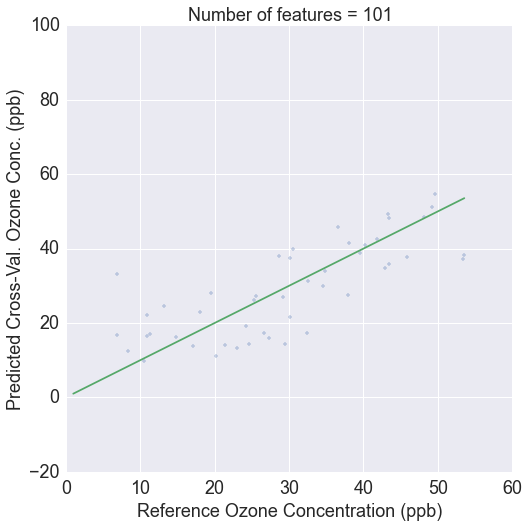

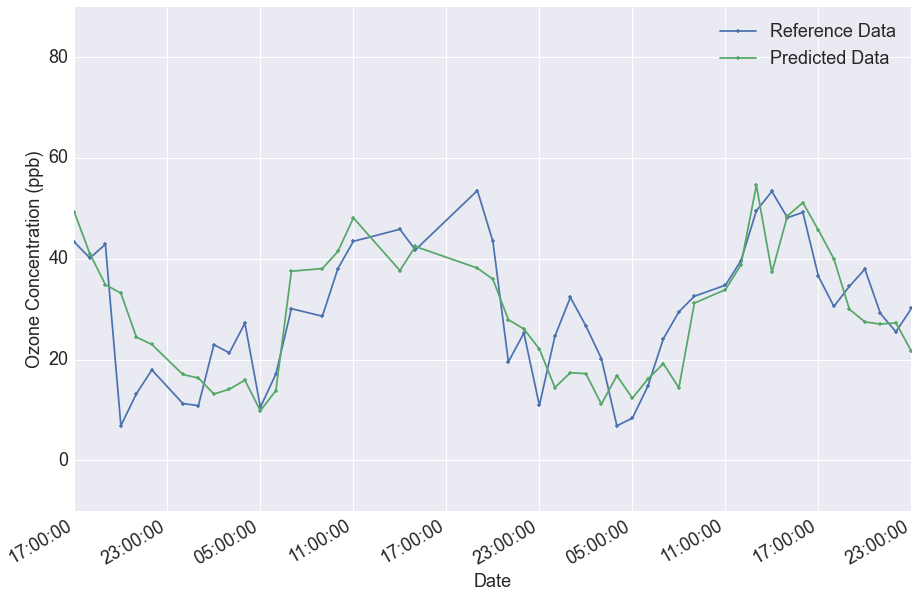

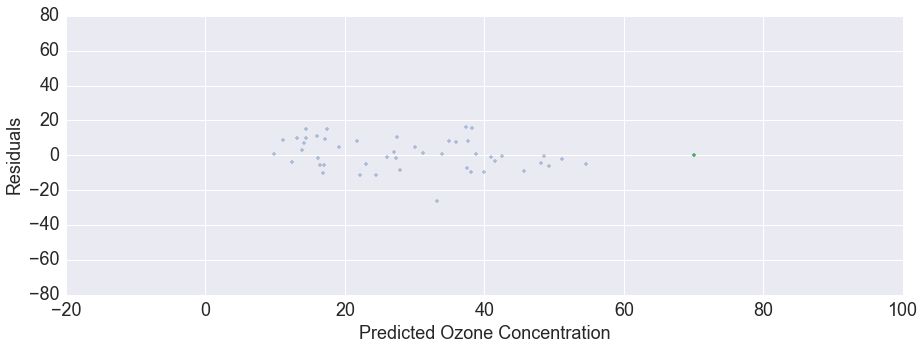

In [248]:
fitted_vs_ref_plot(df_cv_ridge, num_good_feat_ridge, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 0, ref_column)
resid = plot_resid_vs_conc(df_cv_ridge, ref_column)

## Lasso- All Features

In [249]:
best_lambda_lasso, lambda_lasso, coefs_lasso, mean_score_lambda_lasso = find_best_lambda(Lasso, fs_features[:num_good_feat_ridge], df_fits, ref_column, 'custom_mse_scoring_function', days_tr, X, y, 0.000001, 100, 3, cust_mse_fact, cutoff_value)

lambda: 1e-06
score: 24.52
lambda: 3e-06
score: 24.52
lambda: 9e-06
score: 24.51
lambda: 2.7e-05
score: 24.51
lambda: 8.1e-05
score: 24.48
lambda: 0.000243
score: 24.4
lambda: 0.000729
score: 24.16
lambda: 0.002187
score: 23.47
lambda: 0.006561
score: 21.13
lambda: 0.019683
score: 18.01
lambda: 0.059049
score: 12.54
lambda: 0.177147
score: 8.47
lambda: 0.531441
score: 9.74
lambda: 1.594323
score: 10.14
lambda: 4.782969
score: 12.45
lambda: 14.348907
score: 17.46
lambda: 43.046721
score: 17.46
Best Lambda: 0.177147


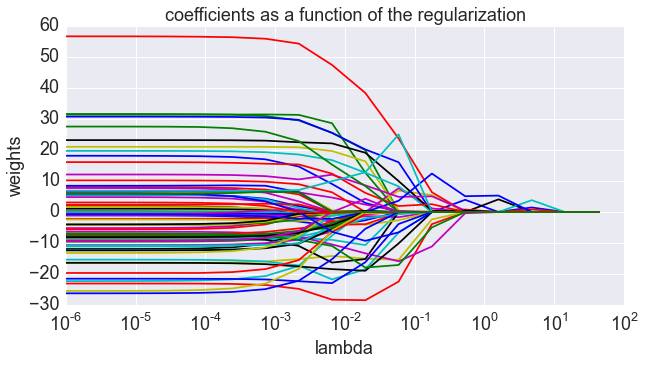

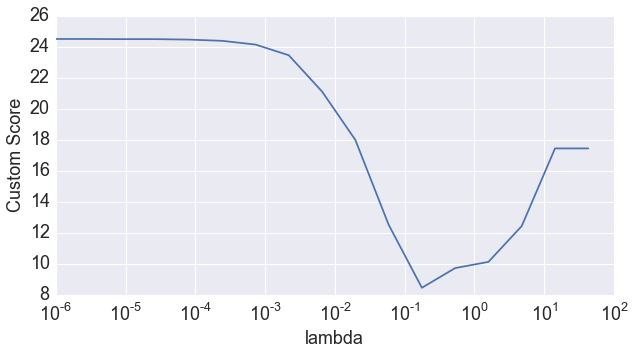

In [250]:
plot_lambda(lambda_lasso, coefs_lasso, mean_score_lambda_lasso)

#### Use the best lambda value found above to find holdout values.

In [251]:
MSE_CV_lasso, MSE_T_lasso, MSE_H_lasso, high_MSE_cv_lasso, X_pred_cv_lasso, y_cv_lasso, df_cv_lasso, df_H_lasso = cross_validation_by_day(Lasso(alpha = best_lambda_lasso), all_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 6.6
Cross-Validation RMSE: 10.0 , High-Value CV RMSE: 14.0 , CV High Diff. in Mean (>40): -14.4
Holdout RMSE: 9.0 , High-Value Holdout RMSE: nan , Holdout High Diff. in Mean.: nan


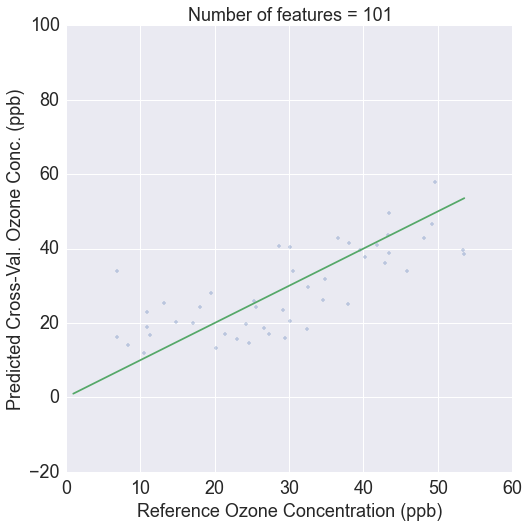

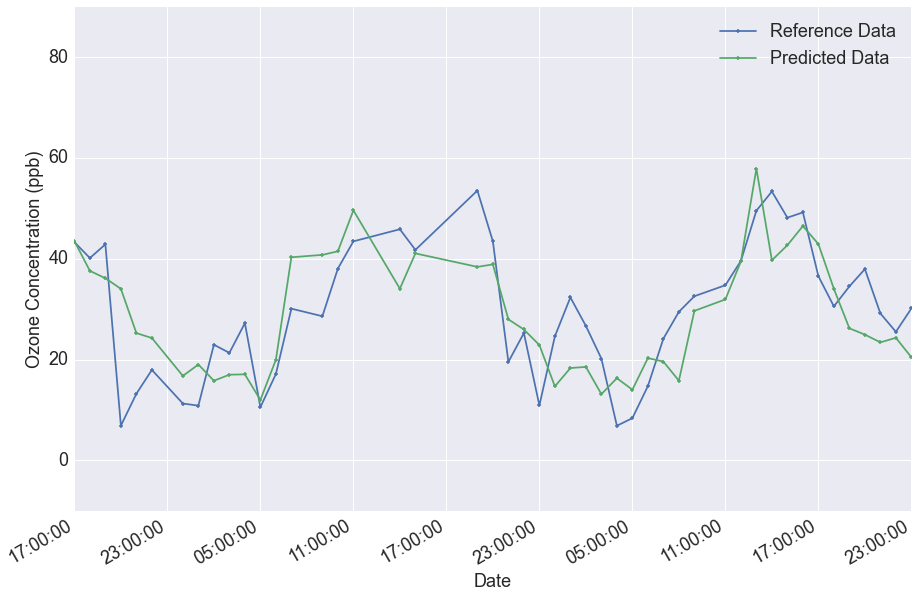

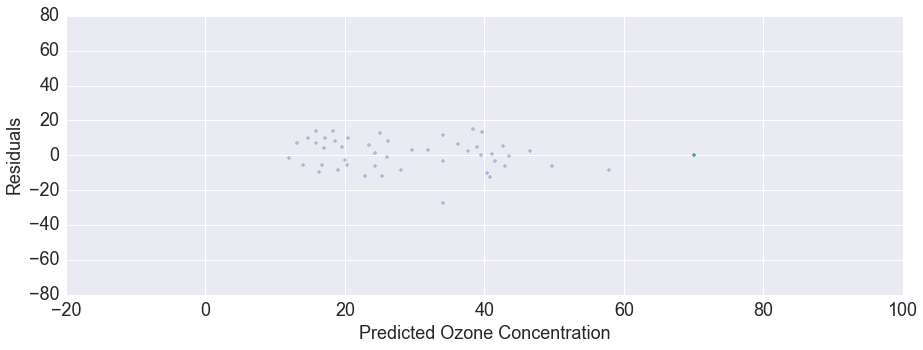

In [252]:
fitted_vs_ref_plot(df_cv_lasso, num_good_feat_ridge, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso, pod_number, 0, ref_column)
resid = plot_resid_vs_conc(df_cv_lasso, ref_column)

## Random Forest- All

In [253]:
MSE_CV, df_fit_rf = find_MSE_random_forest(df_fits, fs_features, days_tr, 0, ref_column)

7-21 Cross-Validation RMSE:  13.5
7-22 Cross-Validation RMSE:  8.4
7-23 Cross-Validation RMSE:  9.6
Overall RMSE: 10.5201793658


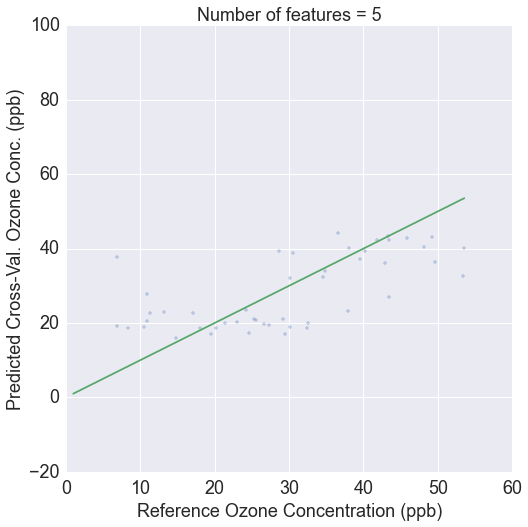

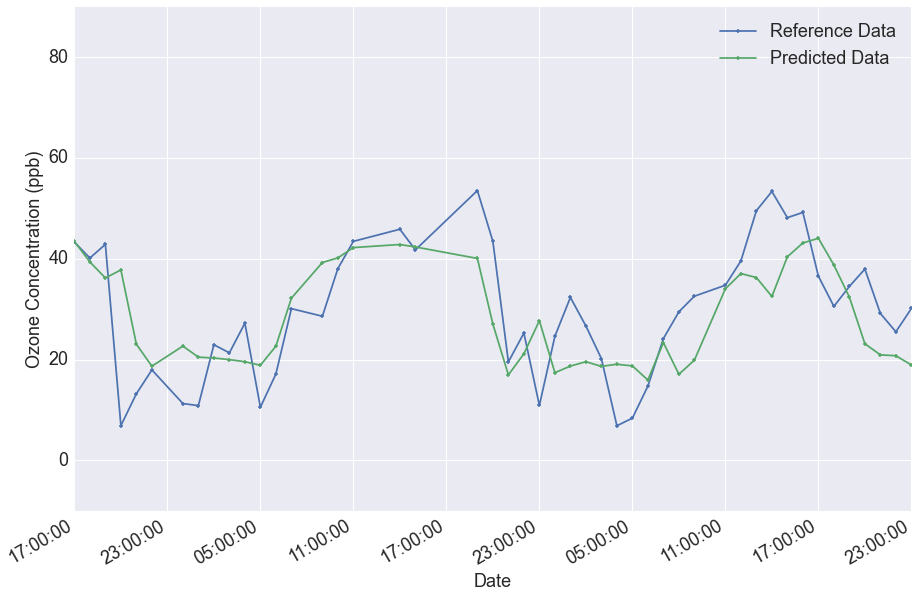

In [254]:
fitted_vs_ref_plot(df_fit_rf, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 0, ref_column)

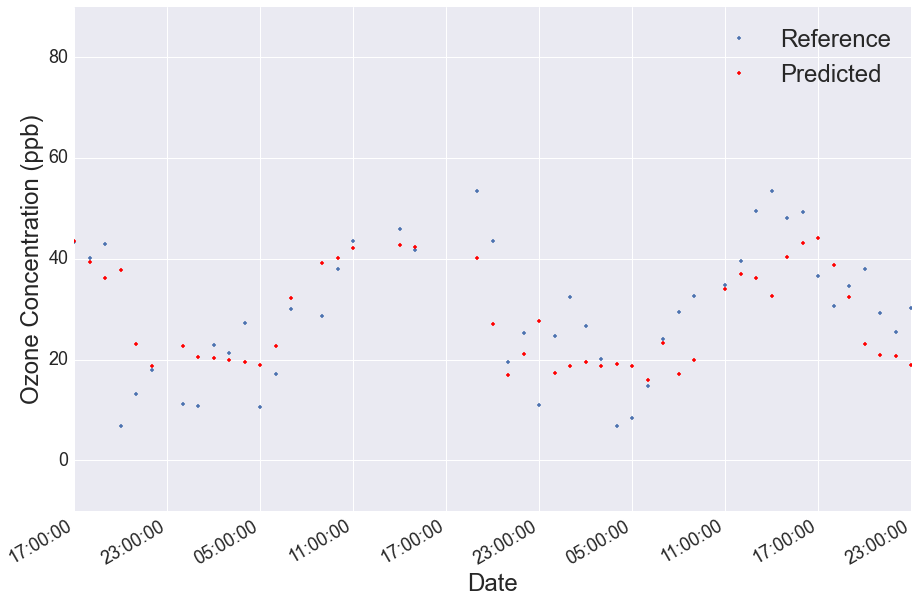

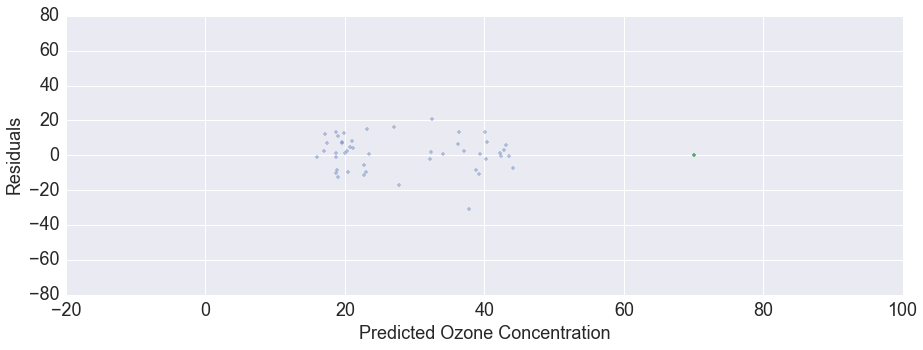

In [255]:
plot_fitted_and_ref_vs_time_no_lines(df_fit_rf, pod_number, 0, ref_column)
resid = plot_resid_vs_conc(df_fit_rf, ref_column)

## Random Forest- Base

In [256]:
MSE_CV_base, df_fit_rf_base = find_MSE_random_forest(df_fits, base_features, days_tr, 0, ref_column)

7-21 Cross-Validation RMSE:  14.4
7-22 Cross-Validation RMSE:  9.0
7-23 Cross-Validation RMSE:  11.1
Overall RMSE: 11.5076744319


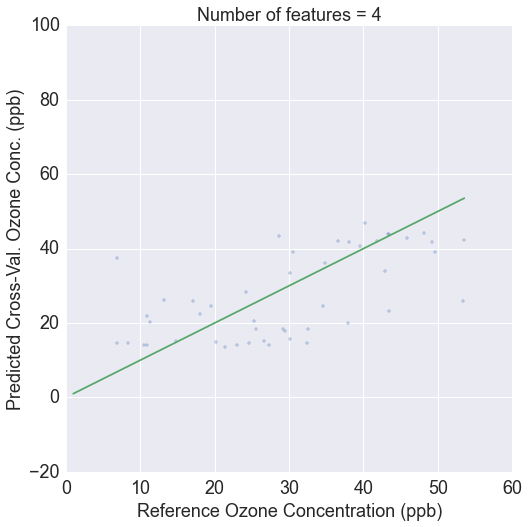

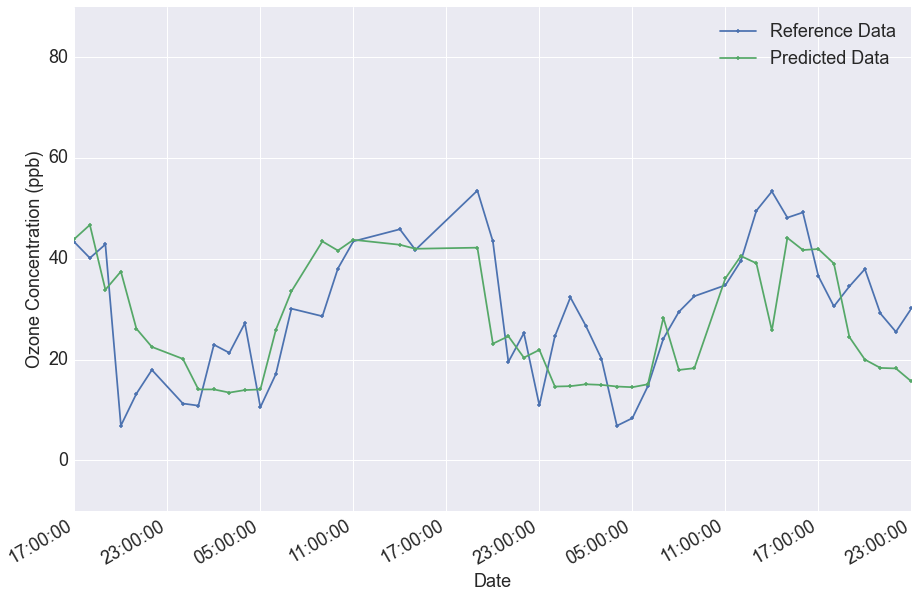

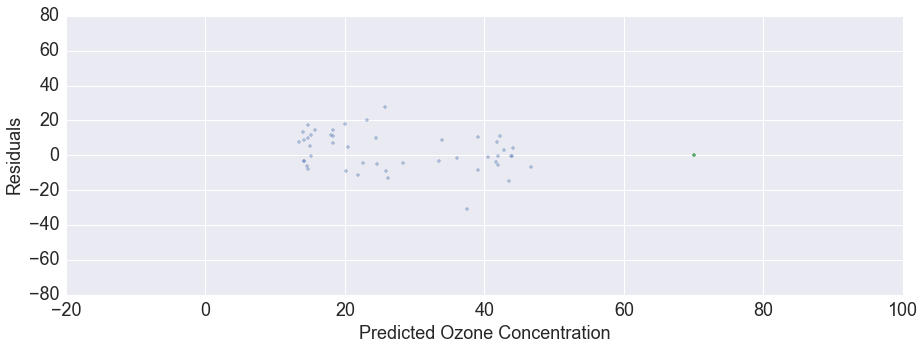

In [257]:
fitted_vs_ref_plot(df_fit_rf_base, 4, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf_base, pod_number, 0, ref_column)
resid = plot_resid_vs_conc(df_fit_rf_base, ref_column)

## Combine data with closed data

#### Find the beginning of each run.

In [58]:
df_scaled[best_features].tail()

,ln_temp,no2,Temp_interact_ln_rh,Temp_slope_lead_5,Temp_slope_lead_1,Temp_slope_lag_5
date,,,,,,
2014-07-25 05:00:00,-1.141652,-1.599016,-1.390974,1.384218,1.463983,1.539827
2014-07-25 06:00:00,-1.155938,-2.140093,-1.296132,1.745862,1.789089,1.869630
2014-07-25 07:00:00,-0.438311,-0.768871,-0.498737,2.469149,2.276748,2.331354
2014-07-25 08:00:00,0.658711,0.545371,0.726522,1.811615,1.951642,1.836650
2014-07-25 09:00:00,1.054817,1.007719,1.081607,2.344564,2.221138,2.209848


In [59]:
X = df_tr[best_features].values
y = df_tr[ref_column].values
lin = lin_regr.fit(X,y)
X_f = df_scaled[best_features].values
y_f = df_scaled[ref_column].values
pred = lin.predict(X_f)
df_pred = pd.DataFrame({'O3_fit':pred, 'O3_ppb': y_f}, index=df_scaled.index)

In [60]:
df_pred.tail()

,O3_fit,O3_ppb
date,,
2014-07-25 05:00:00,26.780541,13.2460
2014-07-25 06:00:00,35.237260,9.3257
2014-07-25 07:00:00,36.202981,27.5340
2014-07-25 08:00:00,39.282675,16.5730
2014-07-25 09:00:00,45.377885,25.4530


In [61]:
df_pred.columns.values

array(['O3_fit', 'O3_ppb'], dtype=object)

In [62]:
df_pred.rename(columns={'O3_fit':'closed_c'}, inplace=True)

In [63]:
df_pred.to_csv("closed_conc_coll_cham4.csv")

#### Import the open concentrations

In [64]:
df_open = pd.DataFrame.from_csv('data/open_conc_coll_cham4.csv')

In [65]:
df_open.head()

,O3_fit,O3_ppb
date,,
2014-07-21 14:00:00,54.439820,47.055
2014-07-21 17:00:00,63.572230,70.817
2014-07-21 18:00:00,54.781319,40.036
2014-07-21 19:00:00,54.220056,28.114
2014-07-21 20:00:00,45.885054,37.407


In [66]:
df_open_close = pd.concat([df_open, df_pred], join='inner', axis=1)

In [67]:
df_open_close.tail()

,O3_fit,O3_ppb,closed_c,O3_ppb
date,,,,
2014-07-25 05:00:00,22.003247,11.246,26.780541,13.2460
2014-07-25 06:00:00,22.897521,14.993,35.237260,9.3257
2014-07-25 07:00:00,17.354723,31.133,36.202981,27.5340
2014-07-25 08:00:00,49.341097,23.450,39.282675,16.5730
2014-07-25 09:00:00,58.770796,33.332,45.377885,25.4530


In [68]:
df_open_close.rename(columns={'O3_fit': 'open_c'}, inplace=True)

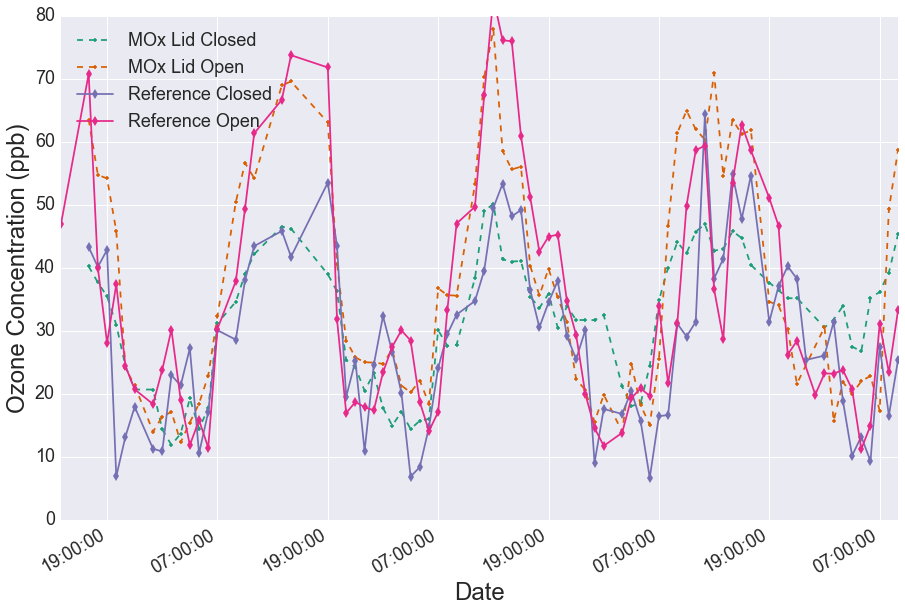

In [69]:
fig = plt.figure(figsize = (15,10), facecolor='w')
df_open_close.closed_c.plot(marker = '.', linestyle='--', label="MOx Lid Closed", color='#1b9e77', ylim = [0,80])
df_open_close.open_c.plot(marker = '.', linestyle='--', label="MOx Lid Open", color='#d95f02', ylim = [0,80])
df_pred[ref_column].plot(marker = 'd',linestyle = '-', label = 'Reference Closed', color='#7570b3', ylim = [0,80])
df_open.O3_ppb.plot(marker = 'd',linestyle = '-',  color='#e7298a', label='Reference Open', ylim = [0,80])
plt.legend(fontsize = 18, loc='best')
plt.ylabel('Ozone Concentration (ppb)', size = 24)
plt.xlabel('Date', size = 24)
plt.savefig('open_close.pdf', facecolor=fig.get_facecolor())

In [70]:
df_open_close.head()

,open_c,O3_ppb,closed_c,O3_ppb
date,,,,
2014-07-21 17:00:00,63.572230,70.817,40.253278,43.3320
2014-07-21 18:00:00,54.781319,40.036,37.704454,40.1730
2014-07-21 19:00:00,54.220056,28.114,35.490288,42.8890
2014-07-21 20:00:00,45.885054,37.407,30.995508,6.9174
2014-07-21 21:00:00,24.095942,24.421,24.417987,13.2470


In [71]:
count = 0
flux = []
close_time = []
open_conc = []
close_conc = []
for idx, row in df_open_close.iterrows():
    try:
        flux.append(-(0.0015/0.1574)*(row['open_c']-row['closed_c'])*584.6529/(298))
        open_conc.append(row['open_c'])
        close_conc.append(row['closed_c'])
        close_time.append(idx)
    except:
        pass
    count += 1

In [72]:
df_flux = pd.DataFrame({'flux':flux, 'open_conc':open_conc, 'close_conc':close_conc}, index=close_time)

In [73]:
df_flux.head()

,close_conc,flux,open_conc
2014-07-21 17:00:00,40.253278,-0.435991,63.572230
2014-07-21 18:00:00,37.704454,-0.319284,54.781319
2014-07-21 19:00:00,35.490288,-0.350188,54.220056
2014-07-21 20:00:00,30.995508,-0.278388,45.885054
2014-07-21 21:00:00,24.417987,0.006021,24.095942


In [74]:
df_flux.to_csv('data/cham4_coll_fluxes.csv')